In [ ]:
# i have used different deep learning models with different embedding of words 

In [11]:
import numpy as np
import pandas as pd

In [13]:
import sys, os, re, csv, codecs
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Conv1D, concatenate, Flatten, Concatenate
from tensorflow.keras.layers import  BatchNormalization, Dropout, Activation, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [16]:
!pip install scikit-learn
from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:00:01


In [18]:
multi_train = pd.read_csv('train.csv')

multi_validation = pd.read_csv('dev.csv')

multi_test = pd.read_csv('test.csv')

In [19]:
# change the column names
multi_train.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"}, inplace=True)
multi_validation.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)
multi_test.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)

In [20]:
multi_train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [21]:
# Drop Duplicates

# keep the first occurance of duplicates for all three datasets and drop the rest

multi_train.drop_duplicates(keep = 'first', inplace=True)
multi_validation.drop_duplicates(keep = 'first', inplace=True)
multi_test.drop_duplicates(keep = 'first', inplace=True)

In [22]:
train = pd.concat([multi_train, multi_validation], axis=0 ) # concat train and validation set 
train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [23]:
test = multi_test  # test set

In [24]:
train.shape, test.shape

((7735, 4), (1640, 4))

In [25]:
y_train = train[['Commenting', 'Staring', 'Touching']].values
y_test = test[['Commenting', 'Staring', 'Touching']].values

## Tokenization and Padding

In [26]:
# Text Data 
description_train_text =list(train['Description'].values)
description_test_text = list(test['Description'].values)

# tokenize the Text data
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# fit on train data
tokenizer.fit_on_texts(description_train_text)     
# transform train and test data
train_description_sequences = tokenizer.texts_to_sequences(description_train_text)
test_description_sequences = tokenizer.texts_to_sequences(description_test_text)

# vocabulary size 
vocab_size = len(tokenizer.word_index) + 1

# pad the sequnce

train_description_padded = pad_sequences(
        train_description_sequences, maxlen=300, dtype='int32', padding='post',  
        truncating='post')                                                  

test_description_padded = pad_sequences(
        test_description_sequences, maxlen=300, dtype='int32', padding='post', 
        truncating='post')                                  

### performance metrics 

In [60]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 3.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [68]:
import tensorflow as tf

# Define functions to compute F1 Score and Hamming Loss
def f1_score(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.greater(y_pred, threshold), tf.float32)
    true_positives = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32), axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    actual_positives = tf.reduce_sum(y_true, axis=0)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)

def hamming_loss(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(tf.math.greater(y_pred, threshold), tf.float32)
    hamming_loss = 1 - tf.reduce_mean(tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32), axis=1))
    return hamming_loss

# Assuming y_test and y_pred are defined
# Compute F1 Score and Hamming Loss
f1_score_value = f1_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

# Print the results
print('F1 Score:', f1_score_value.numpy())
print('Hamming Loss:', hamming_loss_value.numpy())
print('hamming score:',1-hamming_loss_value.numpy())

F1 Score: 0.65530556
Hamming Loss: 0.16707325
hamming score: 0.8329267501831055


In [69]:
# Exact match ratio
def exact_match_ratio(y_true, y_pred):
    MR = np.all(y_pred == y_true, axis=1).mean()
    return MR

In [70]:
# conver probabilities to labels

def prob_to_class(arr):   # converts probailities to class labes based on 0.5 threshold
    r,c = arr.shape
    predict =np.zeros((r, c))
    for i in range(r):
        for j in range(c):
            if arr[i,j]>0.5:
                predict[i,j] = 1
    return predict

# FastText Embeddings

In [27]:
!pip install gensim
!pip install matplotlib
from gensim.models.fasttext import FastText
%matplotlib inline 

In [28]:
import nltk

In [29]:
embedding_size = 300  #  size of the embedding vector. 
window_size = 20    # size of the number of words occurring before and after the word based on which the word representations.
min_word = 5  # minimum frequency of a word in the corpus for which the word representations will be generated
down_sampling = 1e-2   # most frequently occurring word will be down-sampled by a number specified by the down_sampling 

In [30]:
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in description_train_text]

In [34]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=100)

CPU times: user 14min 9s, sys: 4.43 s, total: 14min 14s
Wall time: 4min 54s


In [49]:
embedding_matrix_fast_text = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = ft_model.wv[word] # getting the vector for each word
  except:
    embedding_vector = np.zeros(300)
  
  if embedding_vector is not None:
    embedding_matrix_fast_text[i] = embedding_vector

## Bidirectional LSTM + Conv1D layer with FastText Embedding 

In [54]:
from keras.initializers import Constant

# Assuming max_input is already defined elsewhere in your code
max_input=300
# Print the shape of embedding_matrix_fast_text to confirm it's a NumPy array
print(embedding_matrix_fast_text.shape)

input = Input(shape=(max_input,), name='Description text')  # Input layer with defined shape

try:
    # Use the embedding matrix directly
    embedding_matrix = embedding_matrix_fast_text

    # Initialize the embedding layer without pre-trained weights
    embedding = Embedding(vocab_size, embedding_size, trainable=False)

    # Set the weights of the embedding layer
    embedding.build((None,))
    embedding.set_weights([embedding_matrix])

    # Apply the embedding layer to the input
    embedded_input = embedding(input)

    x = SpatialDropout1D(0.2)(embedded_input)

    z = GlobalMaxPool1D()(x)

    conv = Conv1D(64, 4, activation="relu")(x)

    x = GlobalMaxPool1D()(conv)

    x = Concatenate()([x, z])

    x = Dropout(0.3)(x)

    output = Dense(3, activation="sigmoid")(x)

    model_4_fast_text = Model(inputs=input, outputs=output)

    print("Model creation successful.")
except Exception as e:
    print("An error occurred:", e)

(9384, 300)
Model creation successful.


In [55]:
model_4_fast_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_4_fast_text.fit(train_description_padded, y_train, batch_size=64, epochs=10, validation_data=(test_description_padded, y_test))  

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - binary_accuracy: 0.6945 - loss: 0.6009 - val_binary_accuracy: 0.8057 - val_loss: 0.4421
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - binary_accuracy: 0.8195 - loss: 0.4279 - val_binary_accuracy: 0.8350 - val_loss: 0.3971
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - binary_accuracy: 0.8439 - loss: 0.3860 - val_binary_accuracy: 0.8400 - val_loss: 0.3893
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - binary_accuracy: 0.8590 - loss: 0.3471 - val_binary_accuracy: 0.8415 - val_loss: 0.3886
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - binary_accuracy: 0.8705 - loss: 0.3269 - val_binary_accuracy: 0.8407 - val_loss: 0.3901
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - binary_accuracy: 0.8790 - loss: 0.3020 - val_binary_accuracy: 0.8396 - val_loss: 0.3949
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - binary_accuracy: 0.8897 - loss: 0.2791 - val_binary_accuracy: 0.8386 - val_loss: 0.4044

In [56]:
score = model_4_fast_text.evaluate(test_description_padded, y_test, verbose=1)
print("Loss:", score[0])
print("Accuracy:", score[1])

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8245 - loss: 0.4516
Loss: 0.4253774881362915
Accuracy: 0.8329269289970398


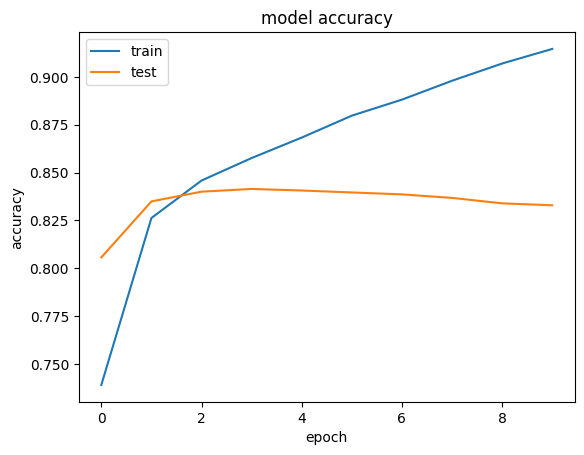

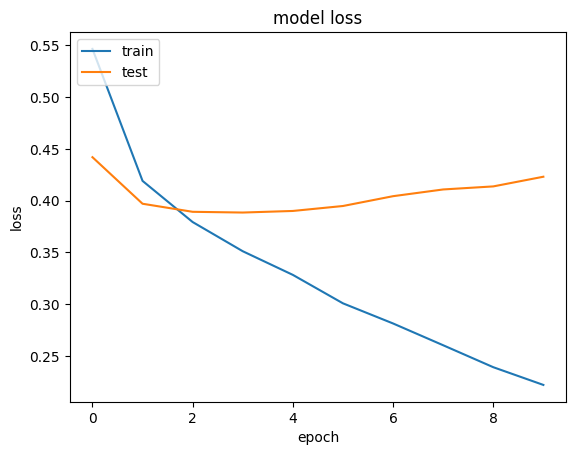

In [58]:
import matplotlib.pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [71]:
y_pred = model_4_fast_text.predict(test_description_padded, batch_size=64)
y_class = prob_to_class(y_pred)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [75]:
print("Hamming Loss: ", hamming_loss(y_test, y_class))
print("Exact Match Ratio: ", exact_match_ratio(y_test, y_class))
print("Recall: ", recall_score(y_test, y_class, average='micro'))
print("Precision: ", precision_score(y_test, y_class, average='micro'))
print("Fl score: ", f1_score(y_true=y_test, y_pred=y_class, threshold=0.5))

Hamming Loss:  tf.Tensor(0.16707325, shape=(), dtype=float32)
Exact Match Ratio:  0.6207317073170732
Recall:  0.6016096579476862
Precision:  0.7973333333333333
Fl score:  tf.Tensor(0.65530556, shape=(), dtype=float32)


In [76]:
# model_4_fast_text.save('model_4_fast_text.h5')
# model_2 = tf.keras.models.load_model('cnn_model.h5') #same file path